![](https://i.pinimg.com/564x/f9/ae/ef/f9aeef0f646f4711bfaf5d837f8766e2.jpg)

# Extended Kalman Filter

Kevin J. Walchko, Phd

21 June 2020

---

### Model

$$
\dot x(t) = f(x(t), u(t)) + w(t) \quad w(t) \sim \mathcal{N}(0,Q(t))\\
z(t) = h(x(t)) + v(t) \quad v(t) \sim \mathcal{N}(0,R(t))
$$

### Initialize

$$
\hat x(t_0) = E[x(t_x)] \\
P(t_0) = Var[x(t_0)]
$$

### Predict-Update

$$
\dot{\hat x}(t) = f(\hat x(t), u(t)) + K(t)(z(t)-h(\hat x(t))) \\
\dot P(t)=F(t)P(t)+P(t)F(t)^T-K(t)H(t)P(t)+Q(t) \\
K(t)=P(t)H(t)^T R(t)^{-1} \\
F(t)=\frac{\partial f}{\partial x} \Bigr|_{\hat x(t), u(t)} \\
H(t)=\frac{\partial h}{\partial x} \Bigr|_{\hat x(t)}
$$

## References

- [Extended Kalman Filter](https://en.wikipedia.org/wiki/Extended_Kalman_filter)

In [1]:
%load_ext autoreload
%autoreload 2

In [284]:
import numpy as np
from numpy.testing import assert_allclose
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)
from math import pi, sin, cos, atan2, asin, acos

from matplotlib import pyplot as plt

from squaternion import Quaternion

from pyrk import RK4

In [3]:
deg2rad = pi/180
rad2deg = 180/pi

In [180]:
from dataclasses import dataclass

@dataclass
class SensorNoise:
    mu: float
    sigma: float
    
    def noise(self, num=1000, dim=1):
        return np.random.normal(self.mu, self.sigma, (num, dim))

@dataclass
class DifferentialDriveKinematics:
    """
    https://www.mathworks.com/help/robotics/ug/mobile-robot-kinematics-equations.html

    Differential Drive Kinematics

    (x,y): position [m]
    theta: heading [rad]
    phiL|R: wheel speed [m/s]
    r: wheel radius [r]
    d: track width, or distance between wheels [m]
    v: speed [m/s]
    w: vehicle heading angular velocity [rad/s]
    """
    r: float
    d: float
    
    def eqns(self, t, x, u):
        theta = x[2]

        phiL = u[0]
        phiR = u[1]

        v = self.r*(phiR + phiL)/2
        w = 2/(2*self.d) * (phiR - phiL)

        ret = np.zeros(3)
        ret[0] = np.cos(theta)*v # x
        ret[1] = np.sin(theta)*v # y
        ret[2] = w               # theta

        return ret

In [335]:
savex = []

robot = DifferentialDriveKinematics(.02,.1)
senpos = SensorNoise(0.0001,0.0001)
senhead = SensorNoise(0.0,0.01)

x = np.zeros(3)
dt = 0.1
rk = RK4(robot.eqns, dt)
times = np.arange(0,20,dt)
# u = [0.1,0.125]
saveu = []

for t in times:
    u = [0.1*np.cos(t/3), 0.1*np.sin(t/3)]
    saveu.append(u)
    x = rk(t,x,u)
    savex.append(x)
    
savex = np.array(savex)
num = len(savex)
sen = np.hstack((senpos.noise(num,2), senhead.noise(num)))
savexn = savex + sen
saveu = np.array(saveu)

print(sen.T @ sen)
sn =  0
print(f"head: mean: {np.mean(sen[:,sn])}  std: {np.std(sen[:,sn])}")

[[0.      0.      0.00003]
 [0.      0.      0.00004]
 [0.00003 0.00004 0.01508]]
head: mean: 0.00010395332828995929  std: 9.430267252695724e-05


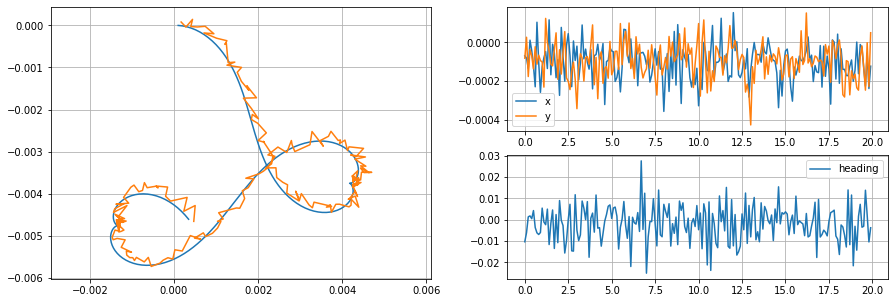

In [336]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(savex[:,0], savex[:,1])
plt.plot(savexn[:,0], savexn[:,1])
plt.axis('equal')
plt.grid(True)

plt.subplot(222)
plt.plot(times,savex[:,0] - savexn[:,0], label="x")
plt.plot(times,savex[:,1] - savexn[:,1], label="y")
plt.legend()
plt.grid(True);

plt.subplot(224)
plt.plot(times, savex[:,2] - savexn[:,2], label="heading")
plt.legend()
plt.grid(True);

In [342]:
ekf = EKF(robot.eqns, dt)
ekf.reset(3,3)
# ekf.R *= [0.01,0.01,0.1]
# ekf.Q *= [.5,.5,10]
ekf.Q *= [5,5,10]

savep = []
save = []

for i in range(num):
    # u = np.array([0.1,0.1])
    u = saveu[i]
    ekf.predict(u)
    
    meas = savexn[i]
    y = ekf.update(meas)
    savep.append(np.trace(ekf.P))
    
    save.append(y)
    
save = np.array(save)
savep = np.array(savep)

trapz:  x: -0.021 y: -0.019 heading: -0.361
x: 0.022 y: 0.021 heading: 1.237


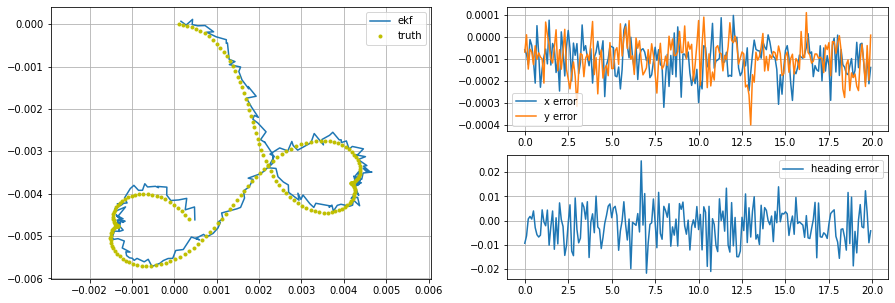

In [343]:
err = savex - save
ex = err[:,0]
ey = err[:,1]
eh = err[:,2]
    

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(save[:,0], save[:,1], label="ekf")
plt.plot(savex[:,0], savex[:,1], "y.", label="truth")
# plt.plot(savexn[:,0], savexn[:,1], label="noisey")
plt.axis('equal')
plt.legend()
plt.grid(True)

plt.subplot(222)
# plt.plot(times, np.cumsum(savex[:,0] - save[:,0], axis=0), label="x cum error")
# plt.plot(times, np.cumsum(savex[:,1] - save[:,1], axis=0), label="y cum error")
plt.plot(times, savex[:,0] - save[:,0], label="x error")
plt.plot(times, savex[:,1] - save[:,1], label="y error")
plt.legend();
plt.grid(True);
plt.subplot(224)
# plt.plot(times, np.cumsum(savex[:,2] - save[:,2], axis=0), label="heading cum error")
plt.plot(times, savex[:,2] - save[:,2], label="heading error")
plt.legend()
plt.grid(True);

print(f"trapz:  x: {np.trapz(ex):.3f} y: {np.trapz(ey):.3f} heading: {np.trapz(eh):.3f}")
print(f"x: {np.sum(np.abs(ex)):.3f} y: {np.sum(np.abs(ey)):.3f} heading: {np.sum(np.abs(eh)):.3f}")

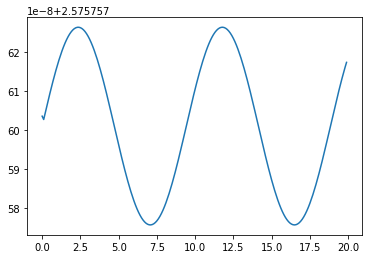

In [344]:
plt.plot(times, savep)

In [346]:
ekf.P

array([[0.83333, 0.     , 0.     ],
       [0.     , 0.83333, 0.     ],
       [0.     , 0.     , 0.90909]])

In [347]:
np.trace(ekf.P)

2.57575761728393

In [348]:
savep

array([2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576, 2.57576,
       2.57576, 2.57

In [296]:

print(f"trapz:  x: {np.trapz(ex):.3f} y: {np.trapz(ey):.3f} heading: {np.trapz(eh):.3f}")
print(f"x: {np.sum(np.abs(ex)):.3f} y: {np.sum(np.abs(ey)):.3f} heading: {np.sum(np.abs(eh)):.3f}")

trapz:  x: -0.052 y: -0.021 heading: -0.095
x: 0.066 y: 0.046 heading: 2.223


In [324]:
@dataclass
class PointMass:
    
    def eqns(self, dt, x, u=None):
        """
        x = [pos, vel, quaternion]
        u = [accels, gyros]
        """
        if u is None:
            u = np.zeros(6)
        else:
            a = u[:3]
            w = u[3:6]

        q = Quaternion(*x[6:])
        
        dp = x[3:6]

        rot = np.array(q.to_rot())
        g = np.array([0,0,9.8])
        dv = rot @ a - g

        W = Quaternion(0,*w)
        dq = 0.5*q*W

        xx = np.array([0,0,0, 0,0,0, dq.w,dq.x,dq.y,dq.z])
        xx[:3] = dp
        xx[3:6] = dv

        return xx

In [333]:
def runPointMass():
    savex = []

    pm = PointMass()
    senpos = SensorNoise(0.1,0.1)
    senhead = SensorNoise(0.0,0.000001)

    x = np.zeros(10)
    x[6] = 1.0
    
    dt = 0.1
    rk = RK4(pm.eqns, dt)
    times = np.arange(0,20,dt)
    u = [0.10,0.10,9.82, 0.0,0.0,0.1]

    for t in times:
        # u = [0.1*np.cos(t/3), 0.1*np.sin(t/3)]
        x = rk(t,x,u)
        savex.append(x)

    savex = np.array(savex)
    num = len(savex)
    sen = np.hstack((senpos.noise(num,6), senhead.noise(num,4)))
    savexn = savex + sen

    # print(sen.T @ sen)
    sn =  0
    print(f"head: mean: {np.mean(sen[:,sn])}  std: {np.std(sen[:,sn])}")
    
    return savex, savexn

sx, sxn = runPointMass()

head: mean: 0.09899163398902115  std: 0.10037956557314477


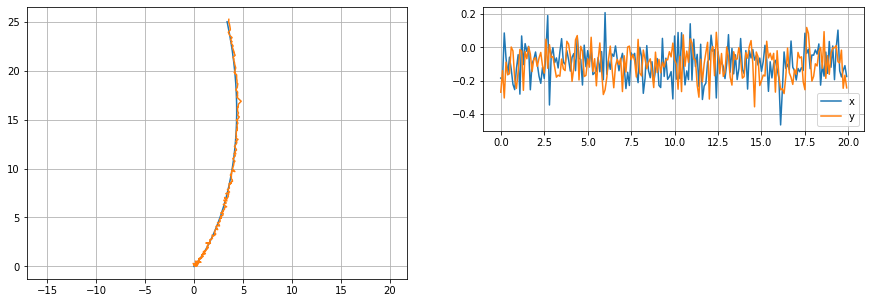

In [334]:
def plotPointMass(savex, savexn):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(savex[:,0], savex[:,1])
    plt.plot(savexn[:,0], savexn[:,1])
    plt.axis('equal')
    plt.grid(True)

    plt.subplot(222)
    plt.plot(times,savex[:,0] - savexn[:,0], label="x")
    plt.plot(times,savex[:,1] - savexn[:,1], label="y")
    plt.legend()
    plt.grid(True);

    # plt.subplot(224)
    # plt.plot(times, savex[:,2] - savexn[:,2], label="heading")
    # plt.legend()
    # plt.grid(True);
    
plotPointMass(sx, sxn)

In [ ]:
def runPMEKF(func, savex, savexn, dt):
    ekf = EKF(func, dt)
    ekf.reset(10,10)
    # ekf.R *= [0.01,0.01,0.1]
    # ekf.Q *= [.5,.5,10]
    # ekf.Q *= [5,5,100]

    p = []
    save = []

    for i in range(num):
        # u = np.array([0.1,0.1])
        ekf.predict(u)

        meas = savexn[i]
        y = ekf.update(meas)
        p.append(np.trace(ekf.P))

        save.append(y)

    save = np.array(save)
    
    err = savex - save
    ex = err[:,0]
    ey = err[:,1]
    eh = err[:,2]


    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(save[:,0], save[:,1], label="ekf")
    plt.plot(savex[:,0], savex[:,1], "y.", label="truth")
    # plt.plot(savexn[:,0], savexn[:,1], label="noisey")
    plt.axis('equal')
    plt.legend()
    plt.grid(True)

    plt.subplot(222)
    # plt.plot(times, np.cumsum(savex[:,0] - save[:,0], axis=0), label="x cum error")
    # plt.plot(times, np.cumsum(savex[:,1] - save[:,1], axis=0), label="y cum error")
    plt.plot(times, savex[:,0] - save[:,0], label="x error")
    plt.plot(times, savex[:,1] - save[:,1], label="y error")
    plt.legend();
    plt.grid(True);
    plt.subplot(224)
    # plt.plot(times, np.cumsum(savex[:,2] - save[:,2], axis=0), label="heading cum error")
    plt.plot(times, savex[:,2] - save[:,2], label="heading error")
    plt.legend()
    plt.grid(True);

    print(f"trapz:  x: {np.trapz(ex):.3f} y: {np.trapz(ey):.3f} heading: {np.trapz(eh):.3f}")
    print(f"x: {np.sum(np.abs(ex)):.3f} y: {np.sum(np.abs(ey)):.3f} heading: {np.sum(np.abs(eh)):.3f}")

In [62]:
# ekf = EKF(func,0.1)
# ekf.reset()

# num = len(data["meas"])

# noise = np.random.uniform(-0.001,0.001,(num,10))

# p = []
# save = []
# ts = []
# t = 0
# for i in range(num):
#     u = np.array([0,0,0,  0,0,0.1])
#     ekf.predict(u)
    
# #     meas = data["meas"][i]
#     y = ekf.update(meas[i,:])
#     p.append(np.trace(ekf.P))
    
#     save.append(y)
#     ts.append(t)
#     t += ekf.dt
    
# save = np.array(save)

In [63]:
# plt.subplot(1,2,1)
# plt.plot(save[:,0],'-r',label='ekf')
# plt.plot(truth[:,0],'-b',label='truth')
# # plt.axis('equal')
# plt.grid(True)

# plt.subplot(1,2,2)
# plt.plot(save[:,0],save[:,1],'-r',label='ekf')
# plt.plot(truth[:,0],truth[:,1],'-b',label='truth')
# plt.plot(meas[:,0],meas[:,1],'-c',label='meas')
# # plt.axis('equal')
# plt.grid(True)
# plt.legend();

In [64]:
# e = np.array([Quaternion(*x).to_euler(degrees=True) for x in save[:,-4:]])
# plt.plot(ts,e[:,0],'-r',label='r')
# plt.plot(ts,e[:,1],'-g',label='p')
# plt.plot(ts,e[:,2],'-b',label='y')
# plt.grid(True)
# plt.legend();

In [65]:
# plt.plot(ts,save[:,6],label="qw")
# plt.plot(ts,save[:,7],label="qx")
# plt.plot(ts,save[:,8],label="qy")
# plt.plot(ts,save[:,9],label="qz")
# q = Quaternion(*save[-1,6:])
# plt.title(f"{q.magnitude}")
# plt.grid(True)
# plt.legend();

In [66]:
# plt.plot(save[:,3],'-r',label='vx')
# plt.plot(save[:,4],'-g',label='vy')
# plt.plot(save[:,5],'-b',label='vz')
# plt.grid(True)
# plt.legend();